In [29]:
import numpy as np
from math import sqrt

class Backwater(object):
    
    def __init__(self,
                 friction = "Chezy",
                 qw = 5.7,
                 initdepth = 10,
                 S = 0.0008,
                 total_x = 10000,
                 dx = 100,
                 alpha = 8.1,
                 n = 2,
                 D90 = .91,
                 D50 = .27,
                 Cz = 22,
                 output_file = "out_Backwater",
                 rho_w = 1000,
                 rho_s = 2650,
                 g = 9.81):
        

        self.friction_ = friction
        self.output_file_ = output_file

        self.qw_ = float(qw)
        self.initdepth_ = float(initdepth)
        self.S_ = float(S)

        self.alpha_ = float(alpha)
        self.n_ = float(n)
        self.D50_ = float(D50) / 1000 # M in old files
        self.D90_ = float(D90) / 1000

        self.Cz_ = float(Cz) 

        self.g_ = float(g)
        self.rho_s_ = float(rho_s)
        self.rho_w_ = float(rho_w)

        self.total_x_ = int(total_x)
        self.dx_ = int(dx)


        ##### DERIVATIVES ######

        self.R = (self.rho_s_ - self.rho_w_) / self.rho_w_

        self.nodes = (self.total_x_ / self.dx_) + 1

        self.U = np.zeros((self.nodes,), dtype = np.float)
        self.taub = np.zeros_like(self.U)
        self.eta = np.zeros_like(self.U)
        self.ksi = np.zeros_like(self.U)
        self.H = np.zeros_like(self.U)
        self.x = np.zeros_like(self.U)


    ################################################
    ################# Functions ####################
    ################################################ 

    ################# Chezy ##################

    def Chezy_formulation(self):

        assert all([self.Cz_]), \
            "One or more variables required for the Chezy formulation are missing"

        self.Hf = ( self.qw_**2 / ( self.Cz_**2 * self.g_ * self.S_ ) )**(1./3)
        
        self.Uf = self.qw_ / self.Hf
        
        self.Fr = self.Uf  / sqrt( self.g_ * self.Hf )
        
        self.taubf = 1000 * ( self.Uf**2 / self.Cz_**2 )

        
        
    def Chezy_Cf(self, Hm_):

        return 1 / self.Cz_**2


    ########### Manning-Strickler ############

    def Manning_formulation(self):

        assert all([self.n_, self.D90_, self.D50_, self.alpha_]), \
            "One or more variables required for the Manning formulation are missing"

        ks = self.n_ * self.D90_
        
        self.Hf = (( ks**(1./3) * self.qw_**2 ) / \
                   ( self.alpha_**2 * self.g_ * self.S_ ))**(1./3)
        
        self.Uf = self.qw_ / self.Hf
        
        self.Fr = self.Uf  / sqrt( self.g_ * self.Hf )
        
        self.taubf = (( ks**(1./3) * self.qw_**2 ) / \
                      ( self.alpha_**2 * self.g_ ))**(1./3) * self.S_**0.7 / \
                      ( self.R * D50_ )

            
            
    def Manning_Cf(self, Hm_):

        return (( self.n_ * self.D90_ ) / Hm_ )**(1./3) / self.alpha_**2


    ########### Shared functions #############

    def get_critical_values(self):

        self.Hcrit = (self.qw_**2 / self.g_) ** (1./3)
        self.Ucrit = self.qw_ / self.initdepth_
    
    
    def calculate_FnH(self, Cf_, H_):

        FnH_ = ( self.S_ - ( Cf_ * self.qw_**2 / ( self.g_ * H_**3 ))) / \
                ( 1 - ( self.qw_**2 / ( self.g_ * H_**3 )))

        return FnH_
    
    
    def update_vals_Fn(self, Cf_fun, i):

        Cf = Cf_fun(self.H[i])
        FnH = self.calculate_FnH(Cf, self.H[i])

        Hp = self.H[i] - FnH * self.dx_

        Cf = Cf_fun(Hp)
        FnHp = self.calculate_FnH(Cf, Hp)

        return FnH, FnHp, Cf

    
    def update_vals(self, i, Cf_):

        self.U[i] = self.qw_ / self.H[i]
        self.taub[i] = 1000 * Cf_ * self.U[i]**2
        self.ksi[i] = self.H[i] + self.eta[i]


    def update_surface(self, i, FnH, FnHp):

#         self.x[i] = self.x[i-1] - self.dx_
        self.H[i] = self.H[i-1] - (0.5 * (FnH + FnHp) * self.dx_)
#         self.eta[i] = self.eta[i-1] + (self.S_ * self.dx_)


    def Backwater_Calculator(self, Cf_fun):

#         self.x[0] = self.total_x_
        self.H[0] = self.initdepth_
#         self.eta[0] = 0
        FnH, FnHp, Cf = self.update_vals_Fn(Cf_fun, 0)
        self.update_vals(0, Cf)

        for i in range(1, self.nodes):

            self.update_surface(i, FnH, FnHp)
            FnH, FnHp, Cf = self.update_vals_Fn(Cf_fun, i)
            self.update_vals(i, Cf)

    def set_surface(self):
        
        self.x[0] = self.total_x_
        self.eta[0] = 0
        
        for i in range(1,self.nodes):
            self.x[i] = self.x[i-1] - self.dx_
            self.eta[i] = self.eta[i-1] + (self.S_ * self.dx_)
            
            
    ##########################################
    ################# Run ####################
    ##########################################   
    def run(self): 

        self.get_critical_values()
        
        self.set_surface()

        if self.friction_ == "Manning":
            self.Manning_formulation()
            self.Backwater_Calculator(self.Manning_Cf)


        if self.friction_ == "Chezy":
            self.Chezy_formulation()
            self.Backwater_Calculator(self.Chezy_Cf)
            
     
    
    ##########################################
    ############## Finalize ##################
    ##########################################   
    def finalize(self):
        
        header1_ = [('Friction formulation', self.friction_),
           ('Depth', str(self.Hf)),
           ('Flow velocity', str(self.Uf)),
           ('Froude number', str(self.Fr)),
           ('Shear stress', str(self.taubf))]
        
        header1 = '\n'.join([','.join(i) for i in header1_])
        
        fields = ['Position', 'Depth', 'FlowVelocity',
                  'ShearStress', 'BedElevation', 'WaterSurfaceElev']
        
        header2 = ', '.join(fields)
        
        header = header1 + "\n\n" + header2
        
        dtype = [(i, float) for i in fields]
        self.data = np.empty(len(self.x), dtype = dtype)
        
        self.data['Position'] = self.x
        self.data['Depth'] = self.H
        self.data['FlowVelocity'] = self.U
        self.data['ShearStress'] = self.taub
        self.data['BedElevation'] = self.eta
        self.data['WaterSurfaceElev'] = self.ksi
        
        np.savetxt(self.output_file_ + '.csv', self.data,
                   header = header,
                   delimiter = ",",
                   fmt = '%10.5f',
                   comments = '')

In [30]:
f= Backwater()

In [31]:
f.run()

In [32]:
f.finalize()

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

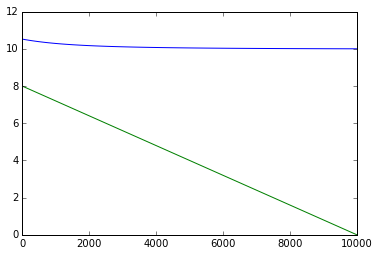

In [34]:
plt.plot(f.x, f.ksi, f.x, f.eta)

In [36]:
f.H

array([ 10.        ,   9.92042584,   9.84086209,   9.76130909,
         9.68176719,   9.60223677,   9.5227182 ,   9.4432119 ,
         9.36371827,   9.28423776,   9.20477082,   9.12531793,
         9.04587958,   8.96645629,   8.88704861,   8.80765709,
         8.72828234,   8.64892496,   8.56958562,   8.49026498,
         8.41096375,   8.33168269,   8.25242257,   8.1731842 ,
         8.09396845,   8.01477622,   7.93560844,   7.85646612,
         7.7773503 ,   7.69826208,   7.6192026 ,   7.54017308,
         7.46117481,   7.38220913,   7.30327746,   7.22438131,
         7.14552224,   7.06670193,   6.98792215,   6.90918475,
         6.83049172,   6.75184513,   6.67324719,   6.59470025,
         6.51620679,   6.43776945,   6.35939101,   6.28107444,
         6.20282291,   6.12463977,   6.0465286 ,   5.9684932 ,
         5.89053763,   5.81266623,   5.73488362,   5.65719473,
         5.57960486,   5.50211964,   5.42474515,   5.34748786,
         5.27035474,   5.19335326,   5.11649146,   5.03

In [23]:
f.x

array([ 123000.,  122000.,  121000.,  120000.,  119000.,  118000.,
        117000.,  116000.,  115000.,  114000.,  113000.,  112000.,
        111000.,  110000.,  109000.,  108000.,  107000.,  106000.,
        105000.,  104000.,  103000.,  102000.,  101000.,  100000.,
         99000.,   98000.,   97000.,   96000.,   95000.,   94000.,
         93000.,   92000.,   91000.,   90000.,   89000.,   88000.,
         87000.,   86000.,   85000.,   84000.,   83000.,   82000.,
         81000.,   80000.,   79000.,   78000.,   77000.,   76000.,
         75000.,   74000.,   73000.,   72000.,   71000.,   70000.,
         69000.,   68000.,   67000.,   66000.,   65000.,   64000.,
         63000.,   62000.,   61000.,   60000.,   59000.,   58000.,
         57000.,   56000.,   55000.,   54000.,   53000.,   52000.,
         51000.,   50000.,   49000.,   48000.,   47000.,   46000.,
         45000.,   44000.,   43000.,   42000.,   41000.,   40000.,
         39000.,   38000.,   37000.,   36000.,   35000.,   340